In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install mlxtend

    100% |████████████████████████████████| 1.3MB 15.9MB/s 


# *Libraries*

---



In [0]:
import gzip, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier

Using TensorFlow backend.


# MNIST Data

---



In [0]:
with gzip.open('mnist.pkl.gz','rb') as ff :
    u = pickle._Unpickler( ff )
    u.encoding = 'latin1'
    train, val, test = u.load()

In [0]:
print( train[0].shape, train[1].shape )
print( val[0].shape, val[1].shape )
print( test[0].shape, test[1].shape )

(50000, 784) (50000,)
(10000, 784) (10000,)
(10000, 784) (10000,)


In [0]:
num_classes = 10
num_features = 784
eta = 0.02
final=[]
final_image=[]
input_size = 784
drop_out = 0.1
first_dense_layer_nodes  = 1568
second_dense_layer_nodes = 10
validation_data_split = 0.0
num_epochs = 50
model_batch_size = 1024
tb_batch_size = 32
early_patience = 100

## Logistic Reression I

---



In [0]:
def softmax(Z, epsilon=1e-9):
    e = np.exp(Z - np.max(Z))
    # very tiny epsilon to the result of softmax function output, to avoid applying logarithm to zeros
    if e.ndim == 1:
        return e / np.sum(e, axis=0) + epsilon
    else:  
        return e / np.array([np.sum(e, axis=1)]).T + epsilon

def infer(W, X):
    #use of np.hstack to add additional column of ones to X;

    X_ones = np.hstack((X, np.ones(((X.shape[0]), 1))))
    XW = np.dot(X_ones, W)
    smax = softmax(XW)
    return smax

def one_hot_encode(labels_list, max_number):
   
    b= np_utils.to_categorical(np.array(labels_list),max_number)
    return b

def loss(W, X, Y):

    m = X.shape[0]
    T = infer(W, X)    
    return (-1 / m) * np.sum(np.log(T) * Y) + eta / 2 * np.sum(W * W)

y_onehot = one_hot_encode(train[1], num_classes)
                          
def get_grad(W, X, Y):
  
    X_alt = np.hstack((X, np.ones(((X.shape[0]), 1))))
    m = X.shape[0]
    T = infer(W, X)   
    return (-1 / m) * np.dot(X_alt.T, (Y - T)) + eta * W

In [0]:
def training(X_train, y_train, batch_size=100, num_epoch=1, n_classes=num_classes, lr=0.001, plot_loss=True):
    
    #Perform gradient descent and return trained weights;
        
    losses = []
    n_features = num_features
    w = np.random.randn(n_features+1, n_classes)/n_features
    for epoch in range(num_epoch):
#         grad = get_grad(w, X_train, one_hot_encode(y_train, n_classes))
#         # print(grad)
#         w = w - step * grad
#         # print(w)
#         losses.append(loss(w, X_train, one_hot_encode(y_train, n_classes)))
        
        for iter_num, (x_batch, y_batch) in enumerate(zip(np.split(X_train, batch_size), np.split(y_train, batch_size))):
            grad = get_grad(w, x_batch, one_hot_encode(y_batch, n_classes))
            gradient_step = lr * grad
            # print(gradient_step)
            w -= gradient_step
            # print(w)
            losses.append(loss(w, x_batch, one_hot_encode(y_batch, n_classes)))
            
    if plot_loss:
        plt.plot(losses)
        plt.title("Loss")
        plt.xlabel("epoch*batches")
        plt.show()
        
    return w

def make_prediction(X, W):

    probability_matrix = infer(W, X)
    return np.array([np.argmax(t) for t in probability_matrix])

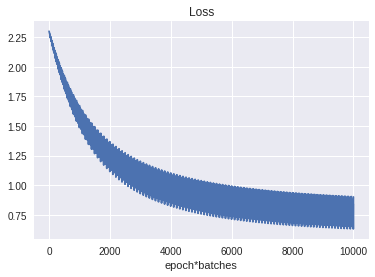

--- 82.18858504295349 seconds ---


In [0]:
import time
start_time = time.time()
W = training(train[0], train[1], num_epoch=100)
print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
print("Validation Logistic Regression I")
right=0
wrong=0
y_pred = make_prediction(val[0], W)
for i,j in zip(val[1],y_pred):
    if i==j:
        right = right + 1
    else:
        wrong = wrong + 1
print("Accuracy: " + str(right/(right+wrong)*100)) 
print(classification_report(val[1], y_pred))
print(confusion_matrix(val[1], y_pred))
print("Testing Logistic Regression I")

right=0
wrong=0
y_pred = make_prediction(test[0], W)
for i,j in zip(test[1],y_pred):
    if i==j:
        right = right + 1
    else:
        wrong = wrong + 1
print("Accuracy: " + str(right/(right+wrong)*100)) 
print(classification_report(test[1], y_pred))
print(confusion_matrix(test[1], y_pred))
final.append(y_pred)

Validation Logistic Regression I
Accuracy: 87.51
             precision    recall  f1-score   support

          0       0.93      0.94      0.93       991
          1       0.86      0.96      0.91      1064
          2       0.89      0.84      0.86       990
          3       0.84      0.87      0.85      1030
          4       0.89      0.88      0.89       983
          5       0.90      0.75      0.82       915
          6       0.91      0.94      0.92       967
          7       0.91      0.88      0.90      1090
          8       0.84      0.82      0.83      1009
          9       0.81      0.86      0.83       961

avg / total       0.88      0.88      0.87     10000

[[ 934    0    7    6    1    1   18    3   17    4]
 [   0 1024    5    5    1    6    3    2   15    3]
 [  11   20  832   15   19    2   24   24   32   11]
 [   5    9   23  894    1   30    8    3   42   15]
 [   0   15    4    0  867    1    8    2   12   74]
 [  17   20   11   82   21  682   26    6   22 

## Neural Network I

---



In [0]:
def get_model():

    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('sigmoid'))
    model.add(Dropout(drop_out))
    
    model.add(Dense(first_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    model.add(Dropout(drop_out))

    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('softmax'))
   
    
    
    model.compile(optimizer='adadelta',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = get_model()
start_time = time.time()
tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=0, patience=early_patience, mode='min')
history = model.fit((train[0])
                    , y_onehot
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/50
50000/50000 [==============================] - 1s 27us/step - loss: 2.5007 - acc: 0.2368
Epoch 2/50
 7168/50000 [===>..........................] - ETA: 0s - loss: 1.8806 - acc: 0.3916

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 1s 22us/step - loss: 1.4296 - acc: 0.5457
Epoch 3/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.9250 - acc: 0.6893
Epoch 4/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.6547 - acc: 0.7846
Epoch 5/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.5559 - acc: 0.8200
Epoch 6/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.4866 - acc: 0.8458
Epoch 7/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.4379 - acc: 0.8660
Epoch 8/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.4274 - acc: 0.8675
Epoch 9/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.3948 - acc: 0.8800
Epoch 10/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.3869 - acc: 0.8838
Epoch 11/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.3722 - acc: 0.8872
Epoch 12/

In [0]:
print("Validation NN I")

right=0
wrong=0
predictedTestLabel=[]
for i,j in zip((val[0]),val[1]):
    y = model.predict(np.array(i).reshape(-1,784))
    
    predictedTestLabel.append(y.argmax())
    
    if j == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1

#print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(val[1], predictedTestLabel))
print(confusion_matrix(val[1], predictedTestLabel))

print("Testing NN I")

right=0
wrong=0
predictedTestLabel=[]
for i,j in zip((test[0]),test[1]):
    y = model.predict(np.array(i).reshape(-1,784))
    
    predictedTestLabel.append(y.argmax())
    
    if j == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1

#print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(test[1], predictedTestLabel))
print(confusion_matrix(test[1], predictedTestLabel))
final.append(predictedTestLabel)

Validation NN I
Accuracy: 94.62
             precision    recall  f1-score   support

          0       0.98      0.96      0.97       991
          1       0.94      0.98      0.96      1064
          2       0.96      0.94      0.95       990
          3       0.91      0.93      0.92      1030
          4       0.96      0.95      0.96       983
          5       0.89      0.93      0.91       915
          6       0.97      0.98      0.97       967
          7       0.96      0.97      0.97      1090
          8       0.96      0.89      0.92      1009
          9       0.93      0.93      0.93       961

avg / total       0.95      0.95      0.95     10000

[[ 956    0    8    2    1    9    6    1    4    4]
 [   0 1048    3    6    1    3    0    0    2    1]
 [   2    5  932   11    6    7    6    9    8    4]
 [   2    4    5  958    1   39    1    3   10    7]
 [   1   10    2    1  932    1    2    2    2   30]
 [   4    1    7   25    3  851   13    2    5    4]
 [   2    3

In [0]:
def accuracy(clf,train,test):
  right=0
  wrong=0
  y_pred = clf.predict(train)
  for i,j in zip(test,y_pred):
      if i==j:
          right = right + 1
      else:
          wrong = wrong + 1
  print("Accuracy: " + str(right/(right+wrong)*100)) 
  print(classification_report(test, y_pred))
  print(confusion_matrix(test, y_pred))
  final.append(y_pred)

## Logistic Regression II & III

---



In [0]:
clf_LR1 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr')
clf_LR2 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
start_time = time.time()
clf_LR1.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
clf_LR2.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))

--- 79.29714560508728 seconds ---
--- 39.824546098709106 seconds ---


In [0]:
accuracy(clf_LR1,test[0],test[1])
accuracy(clf_LR2,test[0],test[1])

Accuracy: 92.06
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       980
          1       0.96      0.98      0.97      1135
          2       0.94      0.89      0.91      1032
          3       0.89      0.91      0.90      1010
          4       0.92      0.94      0.93       982
          5       0.90      0.86      0.88       892
          6       0.94      0.95      0.94       958
          7       0.93      0.92      0.93      1028
          8       0.87      0.88      0.87       974
          9       0.91      0.88      0.89      1009

avg / total       0.92      0.92      0.92     10000

[[ 961    0    1    2    0    4    6    3    1    2]
 [   0 1112    2    1    0    1    4    1   14    0]
 [   8    8  921   18   10    5   12   10   37    3]
 [   4    1   19  919    3   21    4   12   19    8]
 [   1    2    3    3  921    0    9    1    6   36]
 [  10    3    1   40   10  768   16    6   30    8]
 [  10    3    7    2    5 

## Neural Network II & III

---



In [0]:
clf_NN1 = MLPClassifier(solver='adam',alpha=0.01,learning_rate='adaptive',hidden_layer_sizes=(256, 2),random_state=1,max_iter=50)  
clf_NN2 = MLPClassifier(solver='sgd',alpha=0.01,learning_rate='adaptive',hidden_layer_sizes=(256, 2),random_state=1,max_iter=50)    
start_time = time.time()
clf_NN1.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
clf_NN2.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- 188.56582903862 seconds ---
--- 166.13437151908875 seconds ---


In [0]:
accuracy(clf_NN1,test[0],test[1])
accuracy(clf_NN2,test[0],test[1])

Accuracy: 93.4
             precision    recall  f1-score   support

          0       0.91      0.96      0.93       980
          1       0.96      0.98      0.97      1135
          2       0.92      0.90      0.91      1032
          3       0.93      0.91      0.92      1010
          4       0.98      0.96      0.97       982
          5       0.96      0.91      0.93       892
          6       0.94      0.96      0.95       958
          7       0.92      0.94      0.93      1028
          8       0.88      0.91      0.89       974
          9       0.95      0.92      0.93      1009

avg / total       0.93      0.93      0.93     10000

[[ 938    0   14   14    0    0    1    3   10    0]
 [   1 1108    1    0    0    1    5    0   19    0]
 [  35    2  931    7    0   28    1    1   27    0]
 [  45    0    7  921    0    0    0   21   14    2]
 [   0    0    0    0  941    0   10    5    3   23]
 [   6   19   36    3    0  808    5    2   13    0]
 [   1    9    4    1    5  

## Convolutional NN

In [0]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

from keras.layers.convolutional import Conv2D,MaxPooling2D
CNN_model = Sequential()
CNN_model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=(28,28,1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
CNN_model.add(Conv2D(64, (5, 5), activation='sigmoid'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Flatten())
CNN_model.add(Dense(1000, activation='relu'))
CNN_model.add(Dense(10, activation='softmax'))

import keras
import keras.utils
(X_train, y_train)=(train[0],one_hot_encode(train[1], num_classes))
(X_test, y_test)=(test[0],one_hot_encode(test[1], num_classes))
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
CNN_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
CNN_model.fit(X_train, y_train,
          batch_size=64,
          epochs=32,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])

In [0]:
score = CNN_model.evaluate(X_test, y_test, verbose=0)
y_pred=CNN_model.predict(X_test)
y_pred=np.array([np.argmax(t) for t in y_pred])
right=0
wrong=0
for i,j in zip(test[1],y_pred):
    if i==j:
        right = right + 1
    else:
        wrong = wrong + 1
print("Accuracy: " + str(right/(right+wrong)*100)) 
print(classification_report(test[1], y_pred))
print(confusion_matrix(test[1], y_pred))
print('Test accuracy:', score[1])

## Random Forest 

---



In [0]:
clf_RBF1 = RandomForestClassifier(n_estimators=10)
clf_RBF2 = RandomForestClassifier(n_estimators=100)
clf_RBF3 = RandomForestClassifier(n_estimators=200)
start_time = time.time()
clf_RBF1.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
clf_RBF2.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
clf_RBF3.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))


--- 4.440720796585083 seconds ---
--- 44.53623819351196 seconds ---
--- 89.7226333618164 seconds ---


In [0]:
accuracy(clf_RBF1,test[0],test[1])
accuracy(clf_RBF2,test[0],test[1])
accuracy(clf_RBF3,test[0],test[1])


Accuracy: 94.45
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       980
          1       0.98      0.99      0.98      1135
          2       0.91      0.96      0.94      1032
          3       0.92      0.94      0.93      1010
          4       0.94      0.95      0.94       982
          5       0.94      0.91      0.93       892
          6       0.97      0.96      0.96       958
          7       0.96      0.93      0.95      1028
          8       0.94      0.90      0.92       974
          9       0.94      0.92      0.93      1009

avg / total       0.94      0.94      0.94     10000

[[ 967    1    2    1    1    2    2    1    3    0]
 [   0 1119    2    6    1    3    2    1    1    0]
 [   7    1  991    5    4    2    3    7   10    2]
 [   6    0   20  949    1   15    1    8   10    0]
 [   1    3    2    1  930    0    8    0    6   31]
 [  10    1    6   29    3  816    6    6   12    3]
 [  13    4    6    1    7 

In [0]:
m = stats.mode(np.array(final))
print(np.array(final).shape)
right=0
wrong=0
for i,j in zip(test[1], m[0][0]):
    
    if i == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(test[1], m[0][0]))
print(confusion_matrix(test[1], m[0][0]))


(8, 10000)
Errors: 376  Correct :9624
Accuracy: 96.24000000000001
             precision    recall  f1-score   support

          0       0.96      0.99      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.95      0.97      0.96      1032
          3       0.94      0.96      0.95      1010
          4       0.97      0.97      0.97       982
          5       0.96      0.94      0.95       892
          6       0.97      0.97      0.97       958
          7       0.96      0.96      0.96      1028
          8       0.95      0.93      0.94       974
          9       0.97      0.94      0.95      1009

avg / total       0.96      0.96      0.96     10000

[[ 970    0    1    1    0    1    4    1    2    0]
 [   0 1124    2    2    0    1    3    1    2    0]
 [   4    3  996    6    2    0    5    8    8    0]
 [   3    0   12  971    0    8    0    9    7    0]
 [   1    1    3    0  957    0    5    0    2   13]
 [   8    1    1   19    3  83

## Support Vector Machine

---



In [0]:
clf1 = SVC(kernel='linear')
clf2 = SVC(kernel='rbf', gamma=1)
clf3 = SVC(kernel='rbf')
start_time = time.time()
clf1.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
clf3.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))


--- 323.8312437534332 seconds ---
--- 563.8215866088867 seconds ---


In [0]:
start_time = time.time()
clf2.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))
accuracy(clf2,test[0],test[1])

In [0]:
accuracy(clf1,test[0],test[1])
accuracy(clf3,test[0],test[1])

Accuracy: 93.89999999999999
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       980
          1       0.97      0.99      0.98      1135
          2       0.92      0.94      0.93      1032
          3       0.90      0.93      0.92      1010
          4       0.93      0.96      0.95       982
          5       0.92      0.89      0.91       892
          6       0.96      0.95      0.95       958
          7       0.95      0.93      0.94      1028
          8       0.93      0.89      0.91       974
          9       0.95      0.91      0.93      1009

avg / total       0.94      0.94      0.94     10000

[[ 959    0    5    2    2    4    7    0    1    0]
 [   0 1121    3    3    0    1    2    1    4    0]
 [   6    8  968    9    3    2   11   10   13    2]
 [   5    2   17  944    4   13    1    8   13    3]
 [   2    1   10    1  943    0    4    2    2   17]
 [  13    4    2   39    5  792    9    1   22    5]
 [  10    3   1

### Majority Voting

In [0]:
m = stats.mode(np.array(final))
print(np.array(final).shape)
right=0
wrong=0
for i,j in zip(test[1], m[0][0]):
    
    if i == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(test[1], m[0][0]))
print(confusion_matrix(test[1], m[0][0]))

(10, 10000)
Errors: 400  Correct :9600
Accuracy: 96.0
             precision    recall  f1-score   support

          0       0.96      0.99      0.98       980
          1       0.98      0.99      0.98      1135
          2       0.95      0.96      0.96      1032
          3       0.94      0.96      0.95      1010
          4       0.96      0.97      0.97       982
          5       0.95      0.93      0.94       892
          6       0.96      0.97      0.97       958
          7       0.96      0.96      0.96      1028
          8       0.96      0.93      0.94       974
          9       0.97      0.94      0.95      1009

avg / total       0.96      0.96      0.96     10000

[[ 970    0    1    1    0    2    4    1    1    0]
 [   0 1123    2    2    0    1    3    1    3    0]
 [   6    2  994    4    3    1    7    8    6    1]
 [   0    0   12  971    0    9    0   11    7    0]
 [   1    1    4    0  955    0    6    0    2   13]
 [   9    3    1   24    3  829    7    1 

## Bagging

---



In [0]:
bagging1 = BaggingClassifier(base_estimator=clf_LR2, n_estimators=5, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf_NN1, n_estimators=5, max_samples=0.8, max_features=0.8)
bagging3 = BaggingClassifier(base_estimator=clf_RBF1, n_estimators=5, max_samples=0.8, max_features=0.8)
bagging4 = BaggingClassifier(base_estimator=clf1, n_estimators=5, max_samples=0.8, max_features=0.8)
start_time = time.time()
bagging1.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
bagging2.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
bagging3.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
bagging4.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 166.31701064109802 seconds ---


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- 639.8875625133514 seconds ---
--- 12.972444534301758 seconds ---
--- 388.4729747772217 seconds ---


In [0]:
accuracy(bagging1,test[0],test[1])
accuracy(bagging2,test[0],test[1])
accuracy(bagging3,test[0],test[1])
accuracy(bagging4,test[0],test[1])

Accuracy: 92.45
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       980
          1       0.97      0.98      0.97      1135
          2       0.93      0.90      0.91      1032
          3       0.90      0.91      0.91      1010
          4       0.93      0.93      0.93       982
          5       0.91      0.86      0.88       892
          6       0.94      0.95      0.94       958
          7       0.93      0.93      0.93      1028
          8       0.88      0.89      0.88       974
          9       0.91      0.91      0.91      1009

avg / total       0.92      0.92      0.92     10000

[[ 961    0    0    2    0    8    4    4    1    0]
 [   0 1113    3    1    0    1    4    1   12    0]
 [   5    8  929   13   11    5   13    9   35    4]
 [   4    1   21  919    1   21    2   12   23    6]
 [   1    3    7    2  913    0    9    4    9   34]
 [  11    3    4   38    7  770   15    7   32    5]
 [  12    3    8    1    8 

## Boosting

---



In [0]:
boosting4 = AdaBoostClassifier(base_estimator=clf1, n_estimators=5, algorithm='SAMME')
start_time = time.time()
boosting4.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))
accuracy(boosting4,test[0],test[1])

In [0]:
boosting1 = AdaBoostClassifier(base_estimator=clf_LR2, n_estimators=5)
boosting3 = AdaBoostClassifier(base_estimator=clf_RBF1, n_estimators=5)
start_time = time.time()
boosting1.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
boosting3.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))


--- 46.01915431022644 seconds ---
--- 24.029749870300293 seconds ---


In [0]:
accuracy(boosting1,test[0],test[1])
accuracy(boosting3,test[0],test[1])


Accuracy: 85.31
             precision    recall  f1-score   support

          0       0.94      0.88      0.91       980
          1       0.92      0.94      0.93      1135
          2       0.87      0.80      0.83      1032
          3       0.81      0.85      0.83      1010
          4       0.88      0.86      0.87       982
          5       0.73      0.78      0.76       892
          6       0.92      0.87      0.90       958
          7       0.94      0.83      0.88      1028
          8       0.77      0.83      0.80       974
          9       0.78      0.88      0.83      1009

avg / total       0.86      0.85      0.85     10000

[[ 858    0   12    4    0   86   13    2    5    0]
 [   0 1070   11    6    0    7    4    0   37    0]
 [  13   18  822   38   21    8   17   17   71    7]
 [   4    3   16  857    0   58    4   13   42   13]
 [   1    8    6    0  841    5   11    1   14   95]
 [   9   13    5   94   16  697   14    3   21   20]
 [  16    7   28    1   22 

In [0]:
np.array(final).shape
m = stats.mode(np.array(final))
print(m[0][0])
right=0
wrong=0
for i,j in zip(test[1], m[0][0]):
    
    if i == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(test[1], m[0][0]))
print(confusion_matrix(test[1], m[0][0]))

[7 2 1 ... 4 5 6]
Errors: 391  Correct :9609
Accuracy: 96.09
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.98      0.99      0.98      1135
          2       0.95      0.96      0.96      1032
          3       0.94      0.96      0.95      1010
          4       0.96      0.97      0.97       982
          5       0.96      0.93      0.95       892
          6       0.97      0.97      0.97       958
          7       0.97      0.95      0.96      1028
          8       0.95      0.94      0.94       974
          9       0.96      0.94      0.95      1009

avg / total       0.96      0.96      0.96     10000

[[ 970    0    1    1    0    2    4    1    1    0]
 [   0 1120    2    2    0    1    4    1    5    0]
 [   5    2  990    6    3    1    6    8   11    0]
 [   0    0   13  968    0    8    0   10    9    2]
 [   1    1    4    0  955    0    5    0    2   14]
 [   7    3    1   24    3  833    

## Stacking

---



In [0]:
clf_SVM = SVC(kernel='linear', probability=True)
sclf1 = StackingClassifier(classifiers=[clf_SVM, clf_NN1, clf_RBF1], meta_classifier=clf_LR2)
sclf2 = StackingClassifier(classifiers=[clf_SVM, clf_NN1, clf_RBF1], use_probas=True, average_probas=False, meta_classifier=clf_LR2)
sclf3 = StackingClassifier(classifiers=[clf_SVM, clf_NN1, clf_RBF1], use_probas=True, average_probas=True, meta_classifier=clf_LR2)
start_time = time.time()
sclf1.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
sclf2.fit(train[0], train[1]) 
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
sclf3.fit(train[0], train[1])
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- 2159.8025283813477 seconds ---


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- 2159.388486623764 seconds ---


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


--- 2150.5303370952606 seconds ---


In [0]:
accuracy(sclf1,test[0],test[1])
accuracy(sclf2,test[0],test[1])
accuracy(sclf3,test[0],test[1])

Accuracy: 90.85
             precision    recall  f1-score   support

          0       0.99      0.94      0.97       980
          1       0.93      0.97      0.95      1135
          2       0.89      0.91      0.90      1032
          3       0.96      0.89      0.92      1010
          4       0.88      0.91      0.90       982
          5       0.90      0.86      0.88       892
          6       0.91      0.94      0.93       958
          7       0.80      0.93      0.86      1028
          8       0.88      0.86      0.87       974
          9       0.97      0.86      0.91      1009

avg / total       0.91      0.91      0.91     10000

[[ 925   23   20    2    2    2    0    0    6    0]
 [   0 1102   22    2    3    0    2    3    1    0]
 [   1   32  935    8   18    4   12   15    7    0]
 [   0    7   21  894   27   20   13   18   10    0]
 [   0    0    7    4  896   20   27   18    7    3]
 [   0    7    8   16   50  765   12   29    3    2]
 [   1    6    9    0   10 

### Final Majority Voting 

In [0]:

m = stats.mode(np.array(final))
print(np.array(final).shape)
right=0
wrong=0
for i,j in zip(test[1], m[0][0]):
    
    if i == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(test[1], m[0][0]))
print(confusion_matrix(test[1], m[0][0]))

(19, 10000)
Errors: 349  Correct :9651
Accuracy: 96.50999999999999
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.96      0.97      0.96      1032
          3       0.95      0.96      0.95      1010
          4       0.97      0.97      0.97       982
          5       0.97      0.94      0.95       892
          6       0.97      0.97      0.97       958
          7       0.96      0.96      0.96      1028
          8       0.95      0.95      0.95       974
          9       0.97      0.94      0.95      1009

avg / total       0.97      0.97      0.97     10000

[[ 971    0    1    0    0    2    2    1    3    0]
 [   0 1123    2    2    0    1    3    1    3    0]
 [   4    0  998    5    3    0    4    9    9    0]
 [   0    0   10  971    0    8    0   10   10    1]
 [   1    1    4    0  956    0    6    0    2   12]
 [   5    2    1   19    2  8

#**USPS DATA ** 

---


In [0]:
usps_final=[]
def usps_accuracy(clf,train,test):
  right=0
  wrong=0
  y_pred = clf.predict(train)
  for i,j in zip(test,y_pred):
      if i==j:
          right = right + 1
      else:
          wrong = wrong + 1
  print("Accuracy: " + str(right/(right+wrong)*100)) 
  print(classification_report(test, y_pred))
  print(confusion_matrix(test, y_pred))
  usps_final.append(y_pred)

In [0]:
from PIL import Image
import glob
import cv2
image_list = []
target=[]
for i in range(0,10):
    for filename in glob.glob('Numerals/'+str(i)+'/*.png'): 
        print(filename)
        im=cv2.imread (filename)
        im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im=1-(im/255)
        im=np.array(im)
        im=cv2.resize(im, (28, 28)).flatten() 
        image_list.append(im)
        target.append(i)
count=0 
for filename in glob.glob('Test/*.png'): 
    im=cv2.imread (filename)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im=1-(im/255)
    im=np.array(im)
    im=cv2.resize(im, (28, 28)).flatten() 
    image_list.append(im)
    target.append(9-(int(count/150)))
    count=count+1
image_list=np.array(image_list)
print(image_list.shape) 
print(np.array(target).shape) 

(21499, 784)
(21499,)


In [0]:
image_list=image_list[0:19999][:]
target=target[0:19999]
print(image_list.shape) 
print(np.array(target).shape) 

(19999, 784)
(19999,)


## Logistic Regression I

In [0]:
right=0
wrong=0
y_pred = make_prediction(image_list, W)
for i,j in zip(target,y_pred):
    if i==j:
        right = right + 1
    else:
        wrong = wrong + 1
print("Accuracy: " + str(right/(right+wrong)*100)) 
print(classification_report(target, y_pred))
print(confusion_matrix(target, y_pred))
usps_final.append(y_pred)

Accuracy: 34.10170508525427
             precision    recall  f1-score   support

          0       0.24      0.34      0.29      2000
          1       0.34      0.20      0.25      2000
          2       0.37      0.54      0.44      1999
          3       0.40      0.57      0.47      2000
          4       0.44      0.57      0.50      2000
          5       0.44      0.45      0.44      2000
          6       0.50      0.32      0.39      2000
          7       0.20      0.15      0.17      2000
          8       0.21      0.21      0.21      2000
          9       0.16      0.07      0.09      2000

avg / total       0.33      0.34      0.32     19999

[[ 690    7  375   50  350   30   86   29   90  293]
 [ 241  396   55  252  294   57   50  330  309   16]
 [ 314   51 1077  113   89   44  106  102   83   20]
 [ 166    5  121 1136   44  191   49   90  131   67]
 [ 120  104   34   38 1136   79   25  125  229  110]
 [ 219   29  192  240   52  895  120   88  113   52]
 [ 505   14  37

## Neural Network I

In [0]:
right=0
wrong=0
predictedTestLabel=[]
for i,j in zip(image_list,target):
    y = model.predict(np.array(i).reshape(-1,784))
    
    predictedTestLabel.append(y.argmax())
    
    if j == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1

#print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(target, predictedTestLabel))
print(confusion_matrix(target, predictedTestLabel))
usps_final.append(predictedTestLabel)

Accuracy: 39.42697134856743
             precision    recall  f1-score   support

          0       0.53      0.25      0.34      2000
          1       0.56      0.25      0.35      2000
          2       0.51      0.61      0.56      1999
          3       0.41      0.66      0.50      2000
          4       0.58      0.45      0.51      2000
          5       0.29      0.76      0.42      2000
          6       0.76      0.40      0.53      2000
          7       0.23      0.27      0.25      2000
          8       0.28      0.14      0.19      2000
          9       0.22      0.14      0.17      2000

avg / total       0.44      0.39      0.38     19999

[[ 496    2  138   61  181  350   47   57   96  572]
 [  32  508   48  176  146  316   17  652   55   50]
 [  64   30 1228  166   25  351   48   51   19   17]
 [  26    3  110 1327    2  444    2   41   31   14]
 [  16   33   50   25  898  265   25  347  125  216]
 [  41   17   97  167   13 1525   39   57   35    9]
 [ 140    5  36

## Logistic Regression II & III

In [0]:
usps_accuracy(clf_LR1,image_list,target)
usps_accuracy(clf_LR2,image_list,target)

Accuracy: 34.991749587479376
             precision    recall  f1-score   support

          0       0.46      0.31      0.37      2000
          1       0.67      0.28      0.39      2000
          2       0.44      0.60      0.51      1999
          3       0.27      0.45      0.33      2000
          4       0.39      0.44      0.42      2000
          5       0.33      0.69      0.45      2000
          6       0.59      0.30      0.40      2000
          7       0.22      0.29      0.25      2000
          8       0.17      0.09      0.12      2000
          9       0.17      0.06      0.09      2000

avg / total       0.37      0.35      0.33     19999

[[ 627    2  151  137  217  264   70  187   80  265]
 [  62  550   41  209  501  135   25  355   96   26]
 [  93   50 1198  146   77  211   73   81   41   29]
 [  43   10  301  897   19  581    9   58   51   31]
 [  46   42   47   77  880  146   21  476  179   86]
 [  74   15   98  199   48 1375   70   75   32   14]
 [  90    8  5

## Neural Network II & III

In [0]:
usps_accuracy(clf_NN1,image_list,target)
usps_accuracy(clf_NN2,image_list,target)

Accuracy: 37.511875593779685
             precision    recall  f1-score   support

          0       0.26      0.21      0.23      2000
          1       0.39      0.17      0.24      2000
          2       0.40      0.49      0.44      1999
          3       0.38      0.47      0.42      2000
          4       0.74      0.37      0.49      2000
          5       0.70      0.68      0.69      2000
          6       0.58      0.47      0.52      2000
          7       0.20      0.24      0.22      2000
          8       0.23      0.42      0.29      2000
          9       0.24      0.23      0.23      2000

avg / total       0.41      0.38      0.38     19999

[[ 417    8  126  309   62   21   68  341  293  355]
 [  23  339   64  150   15   41   56  430  438  444]
 [ 245   53  989   95    3  138   24   35  403   14]
 [ 384   14  250  935    1   78    4  101  227    6]
 [   9   60   13   69  740    4  290  193  163  459]
 [  72   85  308   37    3 1351   12   17  107    8]
 [  27  168  1

## CNN

In [0]:
(X_test, y_test)=(np.array(image_list),one_hot_encode(target, num_classes))
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
score = CNN_model.evaluate(X_test, y_test, verbose=0)
y_pred=CNN_model.predict(X_test)
y_pred=np.array([np.argmax(t) for t in y_pred])
right=0
wrong=0
for i,j in zip(target,y_pred):
    if i==j:
        right = right + 1
    else:
        wrong = wrong + 1
print("Accuracy: " + str(right/(right+wrong)*100)) 
print(classification_report(target, y_pred))
print(confusion_matrix(target, y_pred))
print('Test accuracy:', score[1])


## RBF

In [0]:
usps_accuracy(clf_RBF1,image_list,target)
usps_accuracy(clf_RBF2,image_list,target)
usps_accuracy(clf_RBF3,image_list,target)

Accuracy: 37.18185909295465
             precision    recall  f1-score   support

          0       0.35      0.31      0.33      2000
          1       0.40      0.37      0.39      2000
          2       0.33      0.58      0.42      1999
          3       0.39      0.58      0.47      2000
          4       0.45      0.52      0.49      2000
          5       0.40      0.62      0.49      2000
          6       0.63      0.32      0.42      2000
          7       0.22      0.26      0.24      2000
          8       0.42      0.09      0.15      2000
          9       0.22      0.07      0.11      2000

avg / total       0.38      0.37      0.35     19999

[[ 620   31  330   77  372  126   98   62   18  266]
 [  32  749  140  160   80   87   34  705    5    8]
 [ 183   71 1151  132   79  155   31  161   16   20]
 [ 102   38  206 1153   57  281   10   94   24   35]
 [  40  174  137   98 1045   96   31  278   37   64]
 [ 128   71  133  234   50 1232   40   80   12   20]
 [ 409   64  28

## SVM

In [0]:
usps_accuracy(clf1,image_list,target)
usps_accuracy(clf3,image_list,target)

Accuracy: 33.97169858492924
             precision    recall  f1-score   support

          0       0.45      0.26      0.33      2000
          1       0.58      0.24      0.34      2000
          2       0.34      0.61      0.44      1999
          3       0.28      0.47      0.35      2000
          4       0.43      0.45      0.44      2000
          5       0.30      0.64      0.41      2000
          6       0.70      0.29      0.41      2000
          7       0.23      0.27      0.25      2000
          8       0.24      0.10      0.14      2000
          9       0.22      0.09      0.12      2000

avg / total       0.38      0.34      0.32     19999

[[ 513    0  302   55  266  311   51  117    6  379]
 [  50  474  150  310  346  172   14  408   48   28]
 [ 179   81 1216  123   55  209   42   51   28   15]
 [  56   59  303  932   12  519    7   45   46   21]
 [  21   24  133   72  900  192    9  464   92   93]
 [  48   11  165  242   74 1280   30   50   79   21]
 [ 158   18  72

In [0]:
usps_accuracy(clf2,image_list,target)


### Majority Voting

In [0]:

m = stats.mode(np.array(usps_final))
print(np.array(usps_final).shape)
right=0
wrong=0
for i,j in zip(target, m[0][0]):
    
    if i == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(target, m[0][0]))
print(confusion_matrix(target, m[0][0]))

(11, 19999)
Errors: 11408  Correct :8591
Accuracy: 42.95714785739287
             precision    recall  f1-score   support

          0       0.46      0.33      0.39      2000
          1       0.55      0.32      0.40      2000
          2       0.45      0.72      0.55      1999
          3       0.45      0.66      0.53      2000
          4       0.55      0.60      0.57      2000
          5       0.37      0.76      0.50      2000
          6       0.76      0.41      0.53      2000
          7       0.23      0.28      0.25      2000
          8       0.33      0.14      0.19      2000
          9       0.25      0.09      0.13      2000

avg / total       0.44      0.43      0.41     19999

[[ 660    1  291   51  322  147   43   78   18  389]
 [  37  638   50  179  230  155   32  630   44    5]
 [ 115   31 1439   79   44  153   39   72   17   10]
 [  54    2  153 1311   10  377    3   57   25    8]
 [  21   93   43   23 1207  134   13  295  104   67]
 [  82   15  119  133   25 

## Boosting

In [0]:
usps_accuracy(boosting1,image_list,target)
usps_accuracy(boosting3,image_list,target)

Accuracy: 32.06160308015401
             precision    recall  f1-score   support

          0       0.63      0.11      0.19      2000
          1       0.36      0.27      0.31      2000
          2       0.34      0.51      0.41      1999
          3       0.47      0.44      0.45      2000
          4       0.46      0.54      0.50      2000
          5       0.22      0.74      0.34      2000
          6       0.62      0.21      0.32      2000
          7       0.20      0.19      0.20      2000
          8       0.28      0.09      0.14      2000
          9       0.22      0.10      0.14      2000

avg / total       0.38      0.32      0.30     19999

[[ 217   14  503   32  403  404   80   53    6  288]
 [  16  537   73  166  204  367    8  566   40   23]
 [  29   78 1021   86   89  467   48  121   44   16]
 [  19    7  114  878   29  726   20   89   46   72]
 [   6  114   56   16 1087  357    7  160   67  130]
 [  17   47  142  137   21 1473   38   78   12   35]
 [  28   16  44

In [0]:
usps_accuracy(boosting4,image_list,target)

In [0]:

m = stats.mode(np.array(usps_final))
print(np.array(usps_final).shape)
right=0
wrong=0
for i,j in zip(target, m[0][0]):
    
    if i == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(target, m[0][0]))
print(confusion_matrix(target, m[0][0]))

(13, 19999)
Errors: 11448  Correct :8551
Accuracy: 42.75713785689285
             precision    recall  f1-score   support

          0       0.49      0.32      0.38      2000
          1       0.52      0.32      0.40      2000
          2       0.45      0.71      0.55      1999
          3       0.47      0.65      0.55      2000
          4       0.54      0.61      0.57      2000
          5       0.35      0.76      0.48      2000
          6       0.77      0.41      0.53      2000
          7       0.23      0.27      0.25      2000
          8       0.34      0.14      0.19      2000
          9       0.24      0.08      0.13      2000

avg / total       0.44      0.43      0.40     19999

[[ 633    1  316   46  354  152   48   62   15  373]
 [  31  648   46  176  189  180   27  664   35    4]
 [ 115   32 1418   72   51  167   36   80   19    9]
 [  51    3  135 1297   15  394    3   64   27   11]
 [  13   99   40   21 1225  154   13  263   98   74]
 [  72   18  127  126   21 

## Bagging

In [0]:
usps_accuracy(bagging1,image_list,target)
usps_accuracy(bagging2,image_list,target)
usps_accuracy(bagging3,image_list,target)
usps_accuracy(bagging4,image_list,target)

Accuracy: 34.69173458672934
             precision    recall  f1-score   support

          0       0.43      0.25      0.32      2000
          1       0.75      0.26      0.39      2000
          2       0.42      0.60      0.49      1999
          3       0.30      0.44      0.35      2000
          4       0.45      0.41      0.43      2000
          5       0.31      0.66      0.43      2000
          6       0.68      0.31      0.43      2000
          7       0.20      0.35      0.26      2000
          8       0.20      0.11      0.14      2000
          9       0.18      0.08      0.11      2000

avg / total       0.39      0.35      0.33     19999

[[ 496    1  141   98  174  275   42  299   60  414]
 [  49  523   35  154  386  171   18  529  106   29]
 [ 100   48 1193  128   55  291   61   57   38   28]
 [  38    8  290  877    9  626    6   76   53   17]
 [  28   12   60   32  818  104   18  654  154  120]
 [  78    7  117  196   45 1321   46  103   62   25]
 [ 128    7  59

In [0]:
m = stats.mode(np.array(usps_final))
print(np.array(usps_final).shape)
right=0
wrong=0
for i,j in zip(target, m[0][0]):
    
    if i == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(target, m[0][0]))
print(confusion_matrix(target, m[0][0]))

(17, 19999)
Errors: 11390  Correct :8609
Accuracy: 43.04715235761788
             precision    recall  f1-score   support

          0       0.50      0.32      0.39      2000
          1       0.55      0.32      0.40      2000
          2       0.45      0.72      0.55      1999
          3       0.45      0.65      0.53      2000
          4       0.55      0.61      0.58      2000
          5       0.36      0.77      0.49      2000
          6       0.79      0.41      0.54      2000
          7       0.23      0.28      0.25      2000
          8       0.35      0.14      0.20      2000
          9       0.24      0.09      0.13      2000

avg / total       0.45      0.43      0.41     19999

[[ 634    1  301   48  332  156   40   71   14  403]
 [  35  640   48  181  197  179   27  657   32    4]
 [  99   33 1438   75   48  174   32   74   15   11]
 [  46    3  162 1297   10  388    2   58   24   10]
 [  15   92   41   18 1226  151   10  281   97   69]
 [  69   15  113  133   24 

## Stacking

In [0]:
usps_accuracy(sclf1,image_list,target)
usps_accuracy(sclf2,image_list,target)
usps_accuracy(sclf3,image_list,target)

Accuracy: 26.696334816740837
             precision    recall  f1-score   support

          0       0.84      0.12      0.21      2000
          1       0.23      0.15      0.18      2000
          2       0.25      0.54      0.34      1999
          3       0.44      0.38      0.41      2000
          4       0.22      0.29      0.25      2000
          5       0.30      0.46      0.36      2000
          6       0.40      0.28      0.33      2000
          7       0.17      0.24      0.20      2000
          8       0.16      0.16      0.16      2000
          9       0.30      0.04      0.07      2000

avg / total       0.33      0.27      0.25     19999

[[ 235  230  421   63  117  222   75  359  161  117]
 [   0  307  492   75   80  195   64  283  499    5]
 [  13  194 1082  199   96  119  141   62   92    1]
 [   4  114  243  750  431  177  142   81   54    4]
 [   0   33  196   49  581  343   71  484  231   12]
 [   4   85  192  124  380  928  116  112   42   17]
 [  11   98  5

### Final Majority Voting

In [0]:
m = stats.mode(np.array(usps_final))
print(np.array(usps_final).shape)
right=0
wrong=0
for i,j in zip(target, m[0][0]):
    
    if i == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))
print("Accuracy: " + str(right/(right+wrong)*100))
print(classification_report(target, m[0][0]))
print(confusion_matrix(target, m[0][0]))

(20, 19999)
Errors: 11260  Correct :8739
Accuracy: 43.69718485924296
             precision    recall  f1-score   support

          0       0.51      0.31      0.39      2000
          1       0.56      0.31      0.40      2000
          2       0.46      0.73      0.56      1999
          3       0.46      0.66      0.54      2000
          4       0.57      0.60      0.59      2000
          5       0.37      0.77      0.50      2000
          6       0.81      0.43      0.56      2000
          7       0.23      0.30      0.26      2000
          8       0.34      0.15      0.21      2000
          9       0.25      0.10      0.14      2000

avg / total       0.46      0.44      0.42     19999

[[ 628    1  289   48  306  154   40   97   22  415]
 [  28  622   53  179  169  172   25  703   42    7]
 [ 104   30 1453   73   46  164   29   75   17    8]
 [  45    4  154 1326    8  372    2   56   26    7]
 [  11   91   42   19 1210  136   11  305  101   74]
 [  66   14  121  133   18 